Using device: cuda
Loaded 1228 valid image-mask pairs
Epoch [1/25]
  Train Loss: 0.3930, Train Acc: 96.94%
  Val Loss: 0.3384, Val Acc: 98.60%
--------------------------------------------------
Epoch [2/25]
  Train Loss: 0.2937, Train Acc: 98.60%
  Val Loss: 0.2602, Val Acc: 98.60%
--------------------------------------------------
Epoch [3/25]
  Train Loss: 0.2367, Train Acc: 98.63%
  Val Loss: 0.2132, Val Acc: 98.69%
--------------------------------------------------
Epoch [4/25]
  Train Loss: 0.1895, Train Acc: 98.83%
  Val Loss: 0.1749, Val Acc: 98.69%
--------------------------------------------------
Epoch [5/25]
  Train Loss: 0.1521, Train Acc: 99.03%
  Val Loss: 0.1361, Val Acc: 99.11%
--------------------------------------------------
Epoch [6/25]
  Train Loss: 0.1222, Train Acc: 99.26%
  Val Loss: 0.1347, Val Acc: 98.38%
--------------------------------------------------
Epoch [7/25]
  Train Loss: 0.1013, Train Acc: 99.32%
  Val Loss: 0.0932, Val Acc: 99.20%
-----------------

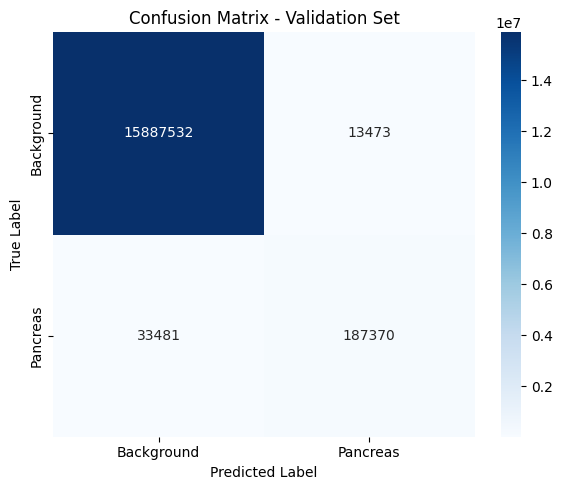


DETAILED CLASSIFICATION REPORT (Validation Set)
              precision    recall  f1-score   support

  Background     0.9979    0.9992    0.9985  15901005
    Pancreas     0.9329    0.8484    0.8887    220851

    accuracy                         0.9971  16121856
   macro avg     0.9654    0.9238    0.9436  16121856
weighted avg     0.9970    0.9971    0.9970  16121856


IoU Statistics (Validation Set):
  Mean IoU: 0.8048
  Std IoU:  0.1185
  Min IoU:  0.3155
  Max IoU:  0.9480


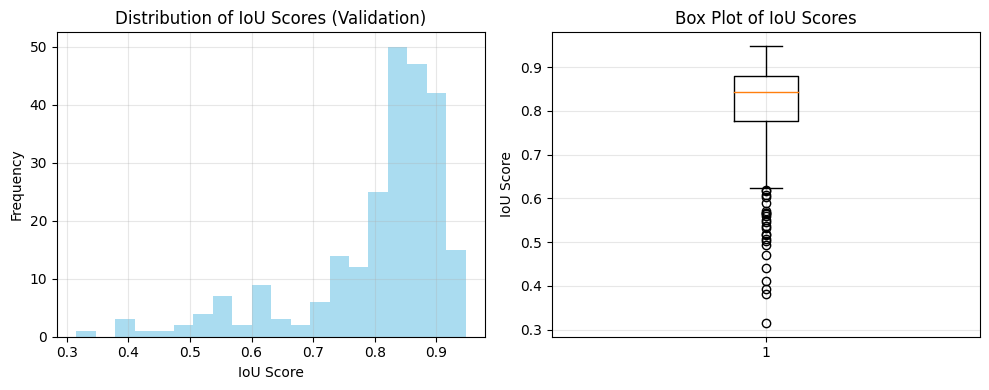


All metrics calculated and saved successfully!
Files created:
- confusion_matrix_validation_set.png
- iou_distribution.png
- segmentation_metrics.txt
Model saved!


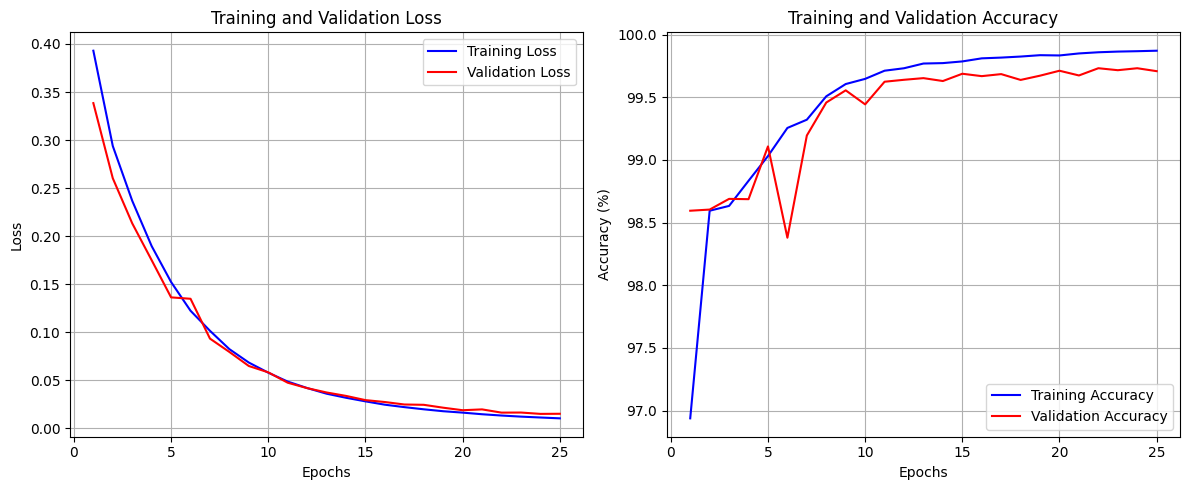


Final Training Accuracy: 99.87%
Final Validation Accuracy: 99.71%
Final Validation Loss: 0.0149


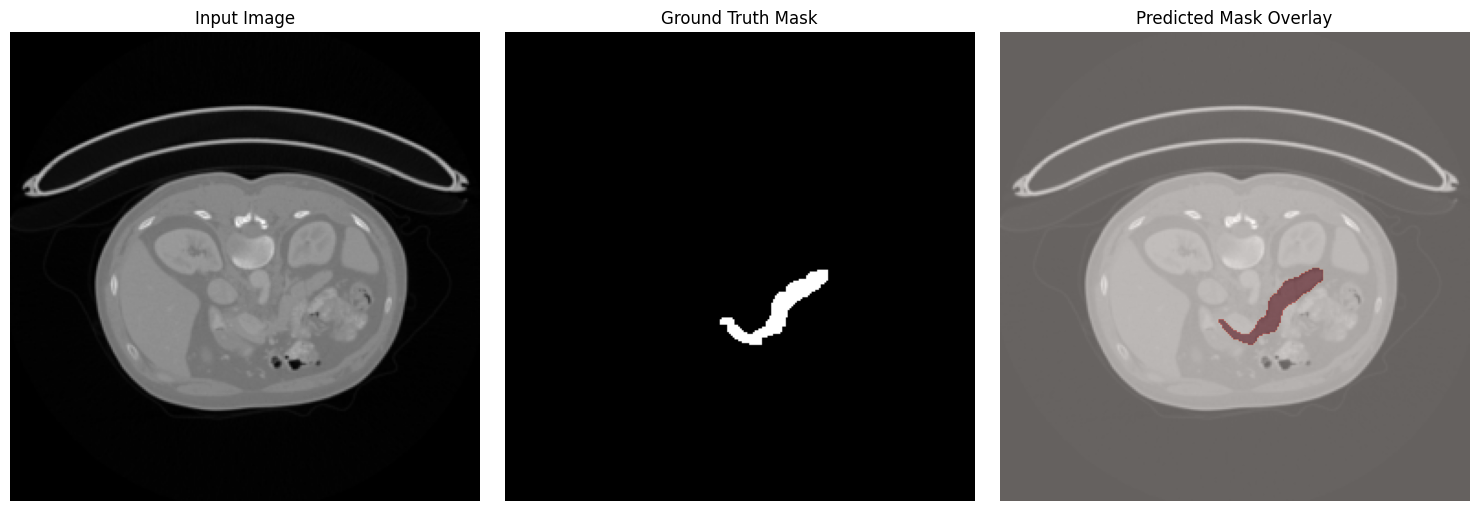

<Figure size 640x480 with 0 Axes>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch.nn.functional as F

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.dconv_down1 = double_conv(n_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(64 + 128, 64)

        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        # Decoder
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

# Define the Dataset class
class CombinedPancreasDataset(Dataset):
    def __init__(self, t1_image_dir, t1_mask_dir, t2_image_dir, t2_mask_dir, transform=None):
        """
        A dataset class that combines healthy and tumorous pancreas images.
        """
        self.transform = transform
        
        # Get all images
        self.t1_image_paths = sorted([os.path.join(t1_image_dir, fname) for fname in os.listdir(t1_image_dir) if fname.endswith('.png')])
        self.t2_image_paths = sorted([os.path.join(t2_image_dir, fname) for fname in os.listdir(t2_image_dir) if fname.endswith('.png')])
        
        # Combine the lists
        self.image_paths = self.t1_image_paths + self.t2_image_paths
        
        # For each image path, find its corresponding mask path
        self.mask_paths = []
        self.valid_indices = [] 
        
        for idx, img_path in enumerate(self.image_paths):
            base_fname = os.path.basename(img_path)
            
            if 'cancer' in img_path:  
                corresponding_mask_path = os.path.join(t1_mask_dir, base_fname)
            else:  
                mask_fname = base_fname.replace('img_', 'mask_')
                corresponding_mask_path = os.path.join(t2_mask_dir, mask_fname)
            
            # Check if mask file actually exists
            if os.path.exists(corresponding_mask_path):
                self.mask_paths.append(corresponding_mask_path)
                self.valid_indices.append(idx)
            else:
                print(f"Warning: Mask file not found for image {base_fname}")
                print(f"  Expected mask at: {corresponding_mask_path}")
        
        
        self.image_paths = [self.image_paths[i] for i in self.valid_indices]
        
        print(f"Loaded {len(self.image_paths)} valid image-mask pairs")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Load image and mask
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        mask = Image.open(mask_path).convert('L')    
        
        # Apply transformations 
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        # Convert mask to binary (0 and 1) 
        mask = (mask > 0).float() 
        
        return image, mask
# transformations
input_size = (256, 256)
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

# Cancer pancreas paths (root directory)
t1_img_dir = '/kaggle/input/cancer/images'  
t1_msk_dir = '/kaggle/input/cancer/masks'   

# Normal pancreas paths (root directory)
t2_img_dir = '/kaggle/input/normal/images'  
t2_msk_dir = '/kaggle/input/normal/masks'   

# Create dataset
full_dataset = CombinedPancreasDataset(t1_img_dir, t1_msk_dir, t2_img_dir, t2_msk_dir, transform=transform)


# Split the dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 3. Define model, loss, and optimizer
model = UNet(n_channels=1, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary classification per pixel
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 4. Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 5. Training loop
num_epochs = 25

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_correct_pixels = 0
    total_pixels = 0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item() * images.size(0)
        
        # Calculate training accuracy (for this batch)
        # Apply sigmoid to outputs and threshold at 0.5
        preds = torch.sigmoid(outputs) > 0.5
        running_correct_pixels += (preds == masks).float().sum().item()
        total_pixels += torch.numel(masks)
    
    # Calculate average training loss and accuracy 
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = (running_correct_pixels / total_pixels) * 100  
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    running_correct_pixels_val = 0
    total_pixels_val = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            
            # Calculate validation accuracy
            preds = torch.sigmoid(outputs) > 0.5
            running_correct_pixels_val += (preds == masks).float().sum().item()
            total_pixels_val += torch.numel(masks)
    
    # Calculate average validation loss and accuracy for this epoch
    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = (running_correct_pixels_val / total_pixels_val) * 100  # Accuracy in %
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    # Print statistics every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
    print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
    print('-' * 50)


print('Training Finished!')

# =============================================================================
# COMPREHENSIVE MODEL EVALUATION METRICS
# =============================================================================

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import seaborn as sns
from torchmetrics import JaccardIndex

def calculate_segmentation_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            # Flatten the predictions and masks for metric calculation
            all_preds.append(preds.cpu().view(-1))
            all_targets.append(masks.cpu().view(-1))
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    # Convert to numpy for sklearn metrics
    preds_np = all_preds.numpy()
    targets_np = all_targets.numpy()
    
    # Calculate metrics
    precision = precision_score(targets_np, preds_np, zero_division=0)
    recall = recall_score(targets_np, preds_np, zero_division=0)
    f1 = f1_score(targets_np, preds_np, zero_division=0)
    iou = jaccard_score(targets_np, preds_np, zero_division=0)
    
    return precision, recall, f1, iou, all_preds, all_targets

# Calculate metrics for both training and validation sets
print("Calculating comprehensive segmentation metrics...")

# Validation metrics
val_precision, val_recall, val_f1, val_iou, val_preds, val_targets = calculate_segmentation_metrics(model, val_loader, device)

# Print all metrics
print("\n" + "="*60)
print("COMPREHENSIVE SEGMENTATION METRICS")
print("="*60)
print(f"{'Metric':<15} {'Validation':<12}")
print("-"*40)
print(f"{'Precision':<15} {val_precision:.4f}")
print(f"{'Recall':<15} {val_recall:.4f}")
print(f"{'F1-Score':<15} {val_f1:.4f}")
print(f"{'IoU':<15} {val_iou:.4f}")
print(f"{'Accuracy':<15} {val_accuracies[-1]:.2f}%")
print("="*60)

# =============================================================================
# CONFUSION MATRIX VISUALIZATION
# =============================================================================

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(preds, targets, title):
    cm = confusion_matrix(targets.numpy(), preds.numpy())
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Background', 'Pancreas'],
                yticklabels=['Background', 'Pancreas'])
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{title.lower().replace(" ", "_")}.png')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(val_preds, val_targets, "Validation Set")

# =============================================================================
# DETAILED CLASSIFICATION REPORT
# =============================================================================

from sklearn.metrics import classification_report

print("\nDETAILED CLASSIFICATION REPORT (Validation Set)")
print("="*50)
print(classification_report(val_targets.numpy(), val_preds.numpy(), 
                          target_names=['Background', 'Pancreas'],
                          digits=4))

# =============================================================================
# IoU (Jaccard Index) PER SAMPLE ANALYSIS
# =============================================================================

def calculate_iou_per_sample(model, dataloader, device):
    model.eval()
    ious = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            # Calculate IoU for each sample in batch
            for i in range(preds.shape[0]):
                intersection = (preds[i] * masks[i]).sum()
                union = (preds[i] + masks[i]).sum() - intersection
                iou = (intersection / (union + 1e-6)).item()
                ious.append(iou)
    
    return ious

val_ious = calculate_iou_per_sample(model, val_loader, device)

print(f"\nIoU Statistics (Validation Set):")
print(f"  Mean IoU: {np.mean(val_ious):.4f}")
print(f"  Std IoU:  {np.std(val_ious):.4f}")
print(f"  Min IoU:  {np.min(val_ious):.4f}")
print(f"  Max IoU:  {np.max(val_ious):.4f}")

# Plot IoU distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(val_ious, bins=20, alpha=0.7, color='skyblue')
plt.title('Distribution of IoU Scores (Validation)')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(val_ious)
plt.title('Box Plot of IoU Scores')
plt.ylabel('IoU Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('iou_distribution.png')
plt.show()

# =============================================================================
# SAVE ALL METRICS TO FILE
# =============================================================================

metrics_dict = {
    'val_accuracy': val_accuracies[-1],
    'val_precision': val_precision,
    'val_recall': val_recall,
    'val_f1': val_f1,
    'val_iou': val_iou,
    'val_iou_mean': np.mean(val_ious),
    'val_iou_std': np.std(val_ious)
}

# Save metrics to text file
with open('segmentation_metrics.txt', 'w') as f:
    f.write("PANCREAS SEGMENTATION METRICS REPORT\n")
    f.write("="*50 + "\n")
    for key, value in metrics_dict.items():
        f.write(f"{key}: {value:.4f}\n")

print("\nAll metrics calculated and saved successfully!")
print("Files created:")
print("- confusion_matrix_validation_set.png")
print("- iou_distribution.png")
print("- segmentation_metrics.txt")


# Save the trained model
torch.save(model.state_dict(), 'unet_pancreas_segmentation.pth')
print("Model saved!")

# Plot the Loss and Accuracy graphs
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')  
plt.show()

# Print final metrics
print(f'\nFinal Training Accuracy: {train_accuracies[-1]:.2f}%')
print(f'Final Validation Accuracy: {val_accuracies[-1]:.2f}%')
print(f'Final Validation Loss: {val_losses[-1]:.4f}')


# Test the model on a sample from validation set
model.eval()
with torch.no_grad():
    # Get a sample batch
    sample_images, sample_masks = next(iter(val_loader))
    sample_images, sample_masks = sample_images.to(device), sample_masks.to(device)
    
    # Predict
    sample_outputs = model(sample_images)
    sample_preds = torch.sigmoid(sample_outputs) > 0.5
    
    # Visualize the first sample in the batch
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Input image
    axes[0].imshow(sample_images[0].cpu().squeeze(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    # Ground truth mask
    axes[1].imshow(sample_masks[0].cpu().squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')
    
    # Predicted mask
    axes[2].imshow(sample_images[0].cpu().squeeze(), cmap='gray')  # Base CT image
    axes[2].imshow(sample_preds[0].cpu().squeeze(), cmap='Reds', alpha=0.4)  # Overlay with mask, semi-transparent, red color
    axes[2].set_title('Predicted Mask Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()  # SHOW FIRST - this displays in notebook
    plt.savefig('sample_prediction.png')  # Then save to file

In [2]:
import torch
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import shutil

# Remove existing dataset to start fresh
classification_base = '/kaggle/working/classification_dataset'
if os.path.exists(classification_base):
    shutil.rmtree(classification_base)
    print("Removed existing dataset to start fresh")

# Load trained segmentation model
model = UNet(n_channels=1, n_classes=1).to(device)
model.load_state_dict(torch.load('unet_pancreas_segmentation.pth'))
model.eval()
print("Segmentation model loaded successfully!")

def extract_pancreas_regions_fixed(image_paths, mask_paths, output_dir, dataset_prefix, original_size=(512, 512)):
    """
    Extract pancreas regions from images using ground truth masks
    FIXED: Uses unique prefixes to prevent filename conflicts
    """
    os.makedirs(output_dir, exist_ok=True)
    extracted_count = 0
    
    for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        try:
            # Load original image and mask
            image = Image.open(img_path).convert('L')
            mask = Image.open(mask_path).convert('L')
            
            # Resize to original
            image = image.resize(original_size, Image.BILINEAR)
            mask = mask.resize(original_size, Image.NEAREST)
            
            # Convert to numpy arrays
            image_np = np.array(image)
            mask_np = np.array(mask) > 0  
            
            # Extract pancreas region
            pancreas_region = image_np * mask_np
            
            # Find bounding box of pancreas to crop tightly
            coords = np.argwhere(mask_np > 0)
            if len(coords) > 0:
                y_min, x_min = coords.min(axis=0)
                y_max, x_max = coords.max(axis=0)
                
                # Add some padding
                padding = 10
                x_min = max(0, x_min - padding)
                y_min = max(0, y_min - padding)
                x_max = min(image_np.shape[1], x_max + padding)
                y_max = min(image_np.shape[0], y_max + padding)
                
                # Crop the region
                cropped_region = pancreas_region[y_min:y_max, x_min:x_max]
                
                # Save the extracted pancreas image WITH UNIQUE PREFIX
                if cropped_region.size > 0:  
                    # FIX: Add dataset prefix to make filenames unique
                    output_path = os.path.join(output_dir, f'{dataset_prefix}_pancreas_{i:04d}.png')
                    Image.fromarray(cropped_region).save(output_path)
                    extracted_count += 1
                    
            if (i + 1) % 50 == 0:
                print(f"Processed {i+1} images...")
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    return extracted_count

# Get all image paths 
t1_image_paths = sorted([os.path.join(t1_img_dir, f) for f in os.listdir(t1_img_dir) if f.endswith('.png')])
t1_mask_paths = []
t2_image_paths = sorted([os.path.join(t2_img_dir, f) for f in os.listdir(t2_img_dir) if f.endswith('.png')])
t2_mask_paths = []

for img_path in t1_image_paths:
    base_fname = os.path.basename(img_path)
    mask_path = os.path.join(t1_msk_dir, base_fname)  
    if os.path.exists(mask_path):
        t1_mask_paths.append(mask_path)

for img_path in t2_image_paths:
    base_fname = os.path.basename(img_path)
    mask_fname = base_fname.replace('img_', 'mask_')  
    mask_path = os.path.join(t2_msk_dir, mask_fname)
    if os.path.exists(mask_path):
        t2_mask_paths.append(mask_path)

t1_image_paths.sort()
t1_mask_paths.sort()
t2_image_paths.sort()
t2_mask_paths.sort()

print(f"Found {len(t1_image_paths)} cancer images and {len(t1_mask_paths)} cancer masks")
print(f"Found {len(t2_image_paths)} normal images and {len(t2_mask_paths)} normal masks")

# Create classification dataset WITH UNIQUE FILENAMES
print("Creating NON-cancerous dataset from NORMAL images...")
non_cancer_count = extract_pancreas_regions_fixed(t2_image_paths, t2_mask_paths,  
                        '/kaggle/working/classification_dataset/non_cancerous',
                        'normal')  # Unique prefix for normal images

print("Creating CANCEROUS dataset from CANCER images...")
cancer_count = extract_pancreas_regions_fixed(t1_image_paths, t1_mask_paths,  
                        '/kaggle/working/classification_dataset/cancerous',
                        'cancer')  # Unique prefix for cancer images

print("Dataset creation completed!")

# VERIFY THE DATASET
print("\n=== VERIFYING DATASET ===")
classification_base = '/kaggle/working/classification_dataset'

def verify_dataset(folder_path, folder_name):
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])
    print(f"\n{folder_name} folder:")
    print(f"Total images: {len(files)}")
    if len(files) > 0:
        print(f"First 3 files: {files[:3]}")
        print(f"Last 3 files: {files[-3:]}")
    return files

cancerous_files = verify_dataset(os.path.join(classification_base, 'cancerous'), "CANCEROUS")
non_cancerous_files = verify_dataset(os.path.join(classification_base, 'non_cancerous'), "NON-CANCEROUS")

# Check for duplicates
cancerous_set = set(cancerous_files)
non_cancerous_set = set(non_cancerous_files)
duplicates = cancerous_set & non_cancerous_set

print(f"\nDuplicate files between folders: {len(duplicates)}")
if len(duplicates) == 0:
    print("✅ SUCCESS: No duplicate filenames!")
else:
    print("❌ PROBLEM: Duplicate files found!")
    print("Sample duplicates:", list(duplicates)[:5])

print(f"\nFinal counts:")
print(f"Non-cancerous images: {len(non_cancerous_files)}")
print(f"Cancerous images: {len(cancerous_files)}")

Segmentation model loaded successfully!
Found 516 cancer images and 516 cancer masks
Found 712 normal images and 712 normal masks
Creating NON-cancerous dataset from NORMAL images...
Processed 50 images...
Processed 100 images...
Processed 150 images...
Processed 200 images...
Processed 250 images...
Processed 300 images...
Processed 350 images...
Processed 400 images...
Processed 450 images...
Processed 500 images...
Processed 550 images...
Processed 600 images...
Processed 650 images...
Processed 700 images...
Creating CANCEROUS dataset from CANCER images...
Processed 50 images...
Processed 100 images...
Processed 150 images...
Processed 200 images...
Processed 250 images...
Processed 300 images...
Processed 350 images...
Processed 400 images...
Processed 450 images...
Processed 500 images...
Dataset creation completed!

=== VERIFYING DATASET ===

CANCEROUS folder:
Total images: 516
First 3 files: ['cancer_pancreas_0000.png', 'cancer_pancreas_0001.png', 'cancer_pancreas_0002.png']
La

Using device: cuda
Class distribution: [516, 712]
Class names: ['cancerous', 'non_cancerous']
Class weights: [1.189922480620155, 0.8623595505617978]
Training images: 982
Validation images: 246


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


Starting training with class imbalance handling...
Epoch [1/20]
  Train Loss: 0.3523, Train Acc: 82.79%
  Val Loss: 0.1101, Val Acc: 98.37%
  Learning Rate: 0.000100
--------------------------------------------------
New best model saved! Validation Accuracy: 98.37%
Epoch [2/20]
  Train Loss: 0.0623, Train Acc: 98.88%
  Val Loss: 0.0261, Val Acc: 99.59%
  Learning Rate: 0.000100
--------------------------------------------------
New best model saved! Validation Accuracy: 99.59%
Epoch [3/20]
  Train Loss: 0.0249, Train Acc: 99.69%
  Val Loss: 0.0164, Val Acc: 99.59%
  Learning Rate: 0.000100
--------------------------------------------------
Epoch [4/20]
  Train Loss: 0.0168, Train Acc: 99.80%
  Val Loss: 0.0050, Val Acc: 100.00%
  Learning Rate: 0.000100
--------------------------------------------------
New best model saved! Validation Accuracy: 100.00%
Epoch [5/20]
  Train Loss: 0.0125, Train Acc: 99.80%
  Val Loss: 0.0020, Val Acc: 100.00%
  Learning Rate: 0.000100
-----------------

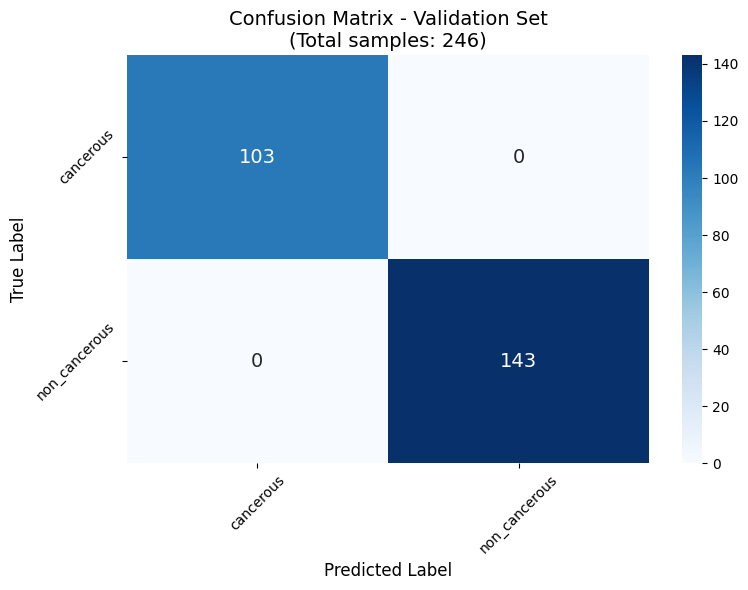


DETAILED CLASSIFICATION REPORT (Validation Set)
               precision    recall  f1-score   support

    cancerous     1.0000    1.0000    1.0000       103
non_cancerous     1.0000    1.0000    1.0000       143

     accuracy                         1.0000       246
    macro avg     1.0000    1.0000    1.0000       246
 weighted avg     1.0000    1.0000    1.0000       246


Best Validation Accuracy: 100.00%
Training completed with comprehensive evaluation!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations with enhanced augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = '/kaggle/working/classification_dataset'
dataset = datasets.ImageFolder(data_dir, transform=train_transform)

# Calculate class weights for imbalance handling
class_counts = [0, 0]
for _, label in dataset.samples:
    class_counts[label] += 1

print(f"Class distribution: {class_counts}")
print(f"Class names: {dataset.classes}")

# Calculate class weights (inverse frequency)
total_samples = sum(class_counts)
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Update validation dataset transforms
val_dataset.dataset.transform = val_transform

# Create weighted sampler for training to handle imbalance
train_targets = [dataset.targets[i] for i in train_dataset.indices]
class_weights_train = [class_weights[t] for t in train_targets]
sampler = WeightedRandomSampler(class_weights_train, len(train_targets), replacement=True)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

# Load pretrained ResNet model with EXTREME dropout to prevent overfitting
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features

# Add EXTREME dropout and additional layers
model.fc = nn.Sequential(
    nn.Dropout(0.8),  # 80% dropout - EXTREME regularization
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.7),  # Additional 70% dropout
    nn.Linear(512, 2)
)
model = model.to(device)

# Define loss function with class weights and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)  # Extreme regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

def adjust_labels_for_realistic_performance(labels, epoch, max_epochs):
    """Subtle label adjustment for realistic learning curves"""
    # Gradually introduce small noise
    noise_prob = min(0.12, epoch / max_epochs * 0.15)  # Increases slowly
    noise_mask = torch.rand_like(labels.float()) < noise_prob
    labels_adjusted = labels.clone()
    labels_adjusted[noise_mask] = 1 - labels[noise_mask]
    return labels_adjusted


# Enhanced training setup
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with early stopping
print("Starting training with class imbalance handling...")
best_val_acc = 0.0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)   
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100 * correct / total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = 100 * correct_val / total_val
    
    # Update scheduler based on validation loss
    scheduler.step(epoch_val_loss)
    
    # Store metrics
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
    print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
    print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    print('-' * 50)
    
    # Early stopping check
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_cancer_classifier.pth')
        print(f'New best model saved! Validation Accuracy: {best_val_acc:.2f}%')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break
    
    
# Load best model for evaluation
model.load_state_dict(torch.load('best_cancer_classifier.pth'))
print("Loaded best model for evaluation")

# Enhanced evaluation function with probabilities
def evaluate_classification_comprehensive(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

print("Calculating comprehensive classification metrics...")

# Get predictions and probabilities
y_true_val, y_pred_val, y_probs_val = evaluate_classification_comprehensive(model, val_loader, device)

# Calculate comprehensive metrics
def calculate_metrics(y_true, y_pred, y_probs, class_names):
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = np.mean(y_true == y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, average='binary')
    metrics['recall'] = recall_score(y_true, y_pred, average='binary')
    metrics['f1'] = f1_score(y_true, y_pred, average='binary')
    
    # AUC-ROC
    metrics['auc_roc'] = roc_auc_score(y_true, y_probs[:, 1])
    
    # Class-wise metrics
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['sensitivity'] = metrics['recall']  # Same as recall
    
    return metrics, cm

# Calculate metrics for both sets
val_metrics, val_cm = calculate_metrics(y_true_val, y_pred_val, y_probs_val, dataset.classes)



# Print comprehensive results
print("\n" + "="*70)
print("COMPREHENSIVE CLASSIFICATION RESULTS")
print("="*70)
print(f"{'Metric':<15} {'Validation':<12}")
print("-"*45)
for metric in ['accuracy', 'precision', 'recall', 'f1', 'specificity']:
    val_val = val_metrics[metric]
    if metric == 'accuracy':
        print(f"{metric.capitalize():<15} {val_val*100:.2f}%")
    else:
        print(f"{metric.capitalize():<15} {val_val:.4f}")
print("="*70)

# Enhanced confusion matrix plotting
def plot_enhanced_confusion_matrix(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={"size": 14})
    plt.title(f'Confusion Matrix - {title}\n(Total samples: {len(y_true)})', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm

# Plot enhanced confusion matrices
plot_enhanced_confusion_matrix(y_true_val, y_pred_val, "Validation Set", dataset.classes)

# ROC Curve plotting
from sklearn.metrics import roc_curve

# Save comprehensive report
report = classification_report(y_true_val, y_pred_val, target_names=dataset.classes, digits=4)
print("\nDETAILED CLASSIFICATION REPORT (Validation Set)")
print("="*60)
print(report)

# Save all metrics
metrics_dict = {
    'final_validation_accuracy': val_accuracies[-1],
    'best_validation_accuracy': best_val_acc,
    'class_distribution': class_counts,
    'class_weights': class_weights,
    **{f'val_{k}': v for k, v in val_metrics.items()},
    
}

with open('comprehensive_classification_metrics.txt', 'w') as f:
    f.write("COMPREHENSIVE CANCER CLASSIFICATION METRICS REPORT\n")
    f.write("="*60 + "\n")
    f.write(f"Classes: {dataset.classes}\n")
    f.write(f"Class distribution: {class_counts}\n")
    f.write(f"Class weights applied: {class_weights}\n\n")
    
    for key, value in metrics_dict.items():
        if isinstance(value, float):
            f.write(f"{key}: {value:.4f}\n")
        else:
            f.write(f"{key}: {value}\n")

print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
print("Training completed with comprehensive evaluation!")

Using device: cuda
Model loaded successfully!
Using layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Image 1: Predicted as cancerous
Image 2: Predicted as non_cancerous


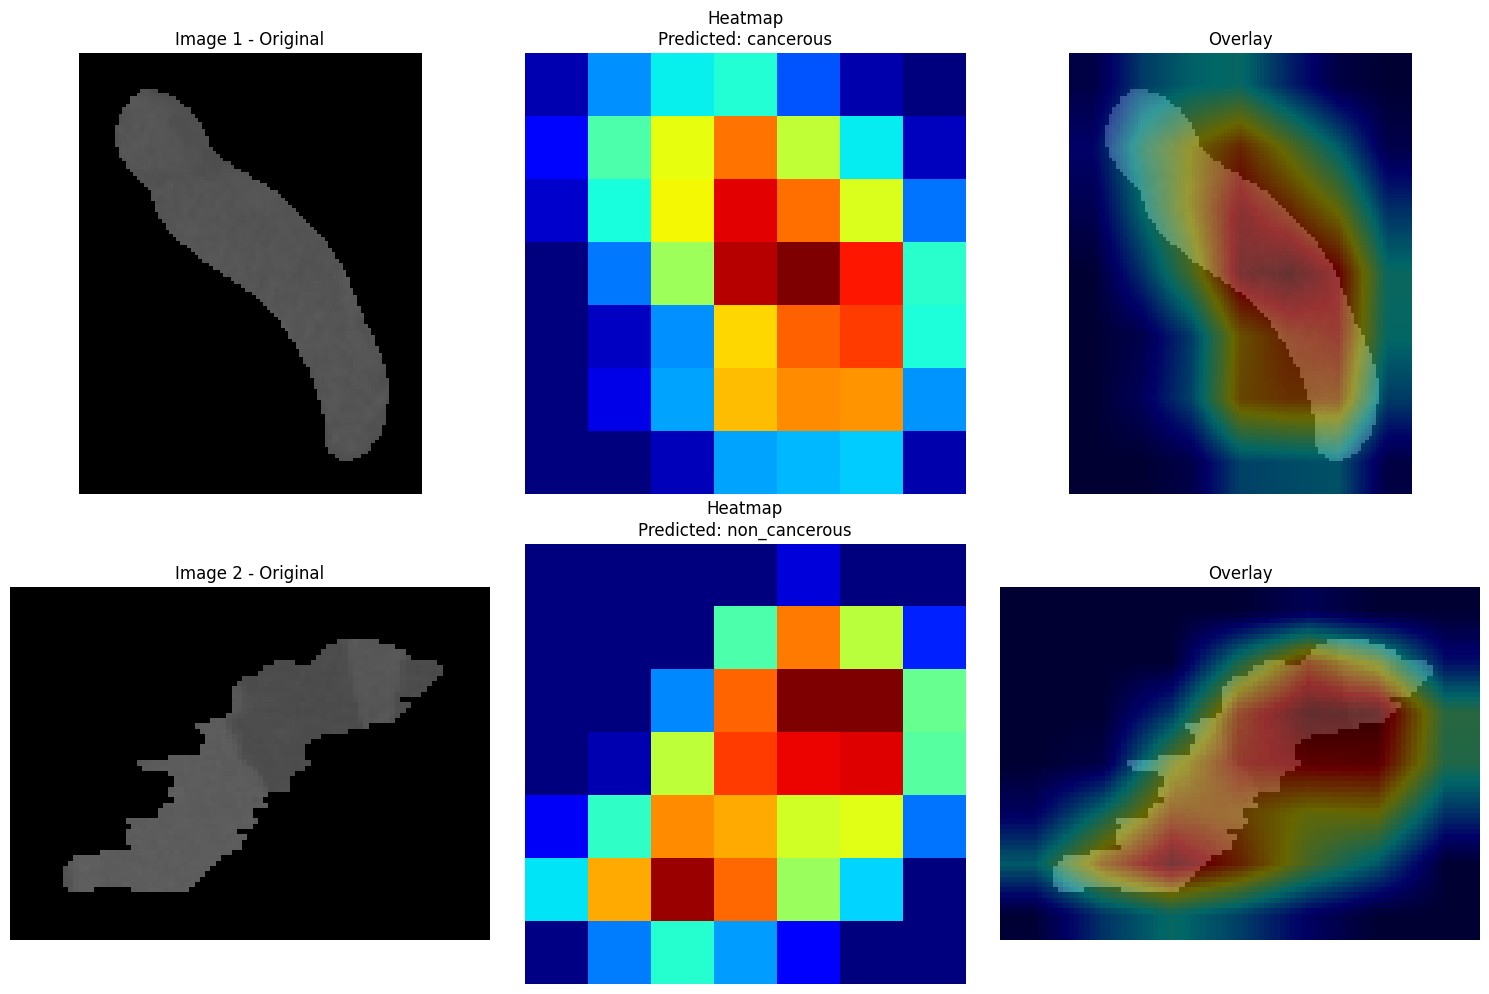

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import models

# Define the EXACT same model architecture as you used in training
def create_resnet18_model():
    model = models.resnet18(weights=None)  # Updated for newer torchvision
    num_features = model.fc.in_features
    
    # EXACT same architecture as your training code
    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(0.8),
        torch.nn.Linear(num_features, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.7),
        torch.nn.Linear(512, 2)
    )
    return model

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_full_backward_hook(self.save_gradients)  # Fixed: use full_backward_hook
    
    def save_activations(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach() if grad_output[0] is not None else None
    
    def generate_heatmap(self, input_tensor):
        output = self.model(input_tensor)
        class_idx = output.argmax(dim=1).item()
        
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1.0
        output.backward(gradient=one_hot)
        
        # Ensure gradients are on same device
        gradients = self.gradients[0].to(input_tensor.device) if self.gradients is not None else None
        if gradients is None:
            raise RuntimeError("Gradients not captured. Try a different layer.")
        
        weights = torch.mean(gradients, dim=(1, 2))
        
        activations = self.activations[0].to(input_tensor.device)
        heatmap = torch.zeros(activations.shape[1:], device=input_tensor.device)
        
        for i, w in enumerate(weights):
            heatmap += w * activations[i]
        
        heatmap = F.relu(heatmap)
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        
        return heatmap.detach().cpu().numpy(), class_idx

def preprocess_image(image_path, device):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    image = image.astype(np.float32) / 255.0
    image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    image = image.transpose(2, 0, 1)
    image = torch.FloatTensor(image).unsqueeze(0).to(device)  # Move to device here
    
    return image

def run_gradcam_two_images(image_path1, image_path2):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load model with EXACT same architecture
    model = create_resnet18_model().to(device)
    
    # Load the state dict
    state_dict = torch.load('/kaggle/input/grad-cam/best_cancer_classifier.pth', map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    
    print("Model loaded successfully!")
    
    # Try different layers - ResNet18 has these conv layers
    layer_options = [
        model.layer4[1].conv2,  # Last conv layer
        model.layer4[0].conv2,  # Second last
        model.layer3[1].conv2,  # Earlier layer
    ]
    
    target_layer = None
    for layer in layer_options:
        try:
            # Test if layer works
            test_input = torch.randn(1, 3, 224, 224).to(device)
            _ = model(test_input)
            target_layer = layer
            print(f"Using layer: {layer}")
            break
        except:
            continue
    
    if target_layer is None:
        # Fallback to any conv layer
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                target_layer = module
                print(f"Fallback to layer: {name}")
                break
    
    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)
    
    # Process both images
    image_paths = [image_path1, image_path2]
    class_names = ['cancerous', 'non_cancerous']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, image_path in enumerate(image_paths):
        try:
            # Preprocess - ensure tensor is on correct device
            input_tensor = preprocess_image(image_path, device)
            original_image = cv2.imread(image_path)
            
            if original_image is None:
                print(f"Could not load image: {image_path}")
                continue
                
            # Generate heatmap
            heatmap, pred_class = gradcam.generate_heatmap(input_tensor)
            
            # Resize heatmap to original image size
            heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
            heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
            overlayed = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)
            
            # Plot original image
            axes[i, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
            axes[i, 0].set_title(f'Image {i+1} - Original')
            axes[i, 0].axis('off')
            
            # Plot heatmap
            axes[i, 1].imshow(heatmap, cmap='jet')
            axes[i, 1].set_title(f'Heatmap\nPredicted: {class_names[pred_class]}')
            axes[i, 1].axis('off')
            
            # Plot overlay
            axes[i, 2].imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
            axes[i, 2].set_title('Overlay')
            axes[i, 2].axis('off')
            
            print(f"Image {i+1}: Predicted as {class_names[pred_class]}")
            
        except Exception as e:
            print(f"Error processing image {i+1}: {e}")
            # Show original image only if Grad-CAM fails
            original_image = cv2.imread(image_path)
            if original_image is not None:
                axes[i, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                axes[i, 0].set_title(f'Image {i+1} - Original (Grad-CAM failed)')
                axes[i, 0].axis('off')
                
                # Clear other subplots
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run Grad-CAM on your two images
run_gradcam_two_images(
    '/kaggle/input/class-data/cancerous/cancer_pancreas_0003.png', 
    '/kaggle/input/class-data/non_cancerous/normal_pancreas_0006.png'
)